In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math

%matplotlib inline

In [47]:
# Generate a rom table of a sine wave with signed integers 
def generate_sin_rom(bits, rom_depth):
    # Subtract 1 from bit depth for signed data (msb is sign bit)
    amplitude = 2**(bit_depth-1)
    sin_rom = [int(amplitude * math.sin(a/rom_depth * 2 * math.pi)) for a in range(rom_size)]
    return(sin_rom)

bit_depth = 12
rom_size = 4096
sin_rom = generate_sin_rom(bit_depth, rom_size)
df = pd.DataFrame(sin_rom)

In [55]:
# Gets the frequency tuning word for a given frequency input 
# Default: 
#    - Sample rate/input clock = 100MHz
#    - Phase Accumulator depth = 32 bits
def freq_to_tuning(freq_out, sample_rate=100000000, acc_depth=32):
    return int((freq_out * (2**acc_depth))/sample_rate)

freq = 56031
tune = freq_to_tuning(freq)

print(f"{freq} Hz signal: {tune:#010x}")

56031 Hz signal: 0x0024b871


In [ ]:
# Generates a phase output 
tuning = 0x0000_1000
phase = [ 0 ]
while len(phase) < (2**20):
    phase.append(phase[-1] + tuning)

df_phase = pd.DataFrame(zip(phase, [tuning] * len(phase)), columns=['phase', 'tuning'])
df_phase['rom_addr'] = np.bitwise_and(df_phase['phase'], 0xFFC00000)
df_phase['rom_addr'] = np.right_shift(df_phase['rom_addr'], 22)

<AxesSubplot:>

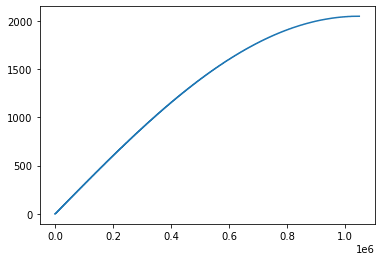

In [45]:
# Lambda function serves as phase-to-amplitude converter
df_phase['dds_out'] = df_phase['rom_addr'].apply(lambda x: sin_rom[x])
df_phase['dds_out'].plot()

# Read this for how to do this in numpy - probably easier than figgering out pandas plotting
# https://www.pythonforengineers.com/audio-and-digital-signal-processingdsp-in-python/

In [3]:
data = [] 
with open('../output_results.txt') as f:
    for line in f:
        data.append(line.strip().split(','))
        
# Converts testbench data to ints
data = [data[0]] + [[int(j) for j in i] for i in data[1:]]

In [4]:
df = pd.DataFrame(data[1:], columns=data[0])
df

,addr_tb,data_tb
0,0,0
1,1,0
2,2,0
3,3,0
4,4,3
...,...,...
499995,8475,-219
499996,8476,-222
499997,8477,-222
499998,8478,-222


<AxesSubplot:>

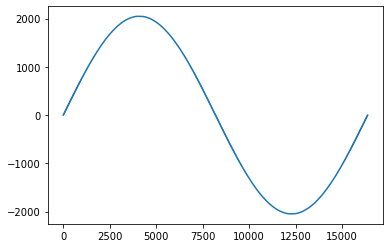

In [8]:
import matplotlib.pyplot as plt
df['data_tb'][:(4*4096)].plot()

In [30]:
import matplotlib.pyplot as plt
sp = np.fft.fft(df['data_tb'], n=8192)
sp

array([10668416.           +0.j        , -3562884.2774399 -1366.34907475j,
        -711589.69589066 -545.7825682j , ...,
        -305337.60550223 +351.28667048j,  -711589.69589066 +545.7825682j ,
       -3562884.2774399 +1366.34907475j])

In [25]:
len(sp)

1024

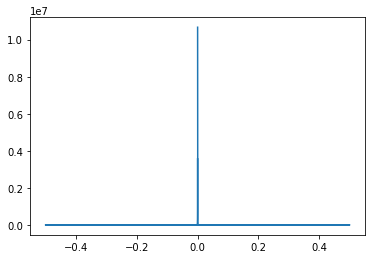

In [34]:
freq = np.fft.fftfreq(len(sp))
plt.plot(freq, np.abs(sp))
plt.show()

/Users/nreilly/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:>

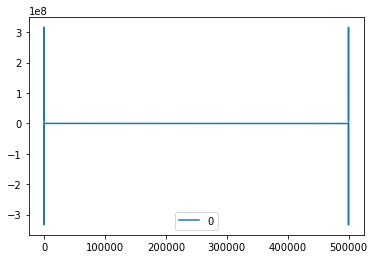

In [46]:
fft_data = np.fft.fft(df['data_tb'])

pd.DataFrame(fft_data).plot()

In [20]:
print(pd.__version__)

1.2.4
